# Image segmentation


## What is image segmentation?
So far you have seen image classification, where the task of the network is to assign a label or class to an input image. However, suppose you want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc. In this case you will want to segment the image, i.e., each pixel of the image is given a label. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.


In [108]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-37qo20a6
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-37qo20a6
  Created wheel for tensorflow-examples: filename=tensorflow_examples-511baa3fbf7f049c853d2a4d43a5a75f3f548b96_-cp37-none-any.whl size=265846 sha256=06d49e72d4c5e5059ec4614a146947bd6dc9253e1b1bd3e1887d7157c321ba56
  Stored in directory: /tmp/pip-ephem-wheel-cache-92h1zopo/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [109]:
!pip install tensorflow_addons
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import os

In [110]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [111]:
%cd /content/gdrive/MyDrive/mila/
#!unzip train.zip

/content/gdrive/MyDrive/mila


In [112]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
#from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import matplotlib.image as mpimg
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import asarray
import matplotlib.pyplot as plt
import PIL
from tensorflow.python.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from keras.layers import Input
from sklearn.metrics import confusion_matrix
import gc
import math
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from skimage.transform import resize


from subprocess import call
import argparse
import glob
import os
import torch
import re

In [113]:
img_path = '/content/gdrive/MyDrive/mila/train/img/'
mask_path = '/content/gdrive/MyDrive/mila/train/mask/'

img_dir = os.listdir('/content/gdrive/MyDrive/mila/train/img/')
mask_dir = os.listdir('/content/gdrive/MyDrive/mila/train/mask/')
#shuffle(all_files)

img_dir = sorted(img_dir)
mask_dir = sorted(mask_dir)

split = int(0.92 * len(img_dir))

#split into training and testing
train_img_filenames = img_dir[0:split]
test_img_filenames  = img_dir[split:]


train_mask_filenames = mask_dir[0:split]
test_mask_filenames  = mask_dir[split:]

#train_img_filenames, train_img_filenames, train_mask_filenames, test_mask_filenames = train_test_split(img_dir, mask_dir, test_size=0.2, random_state=42)

num_train_examples = len(train_mask_filenames)
num_val_examples = len(test_mask_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

print(train_img_filenames)
print(train_mask_filenames)

#train_generator = image_generator(train_files, batch_size = batch_size)
#test_generator  = image_generator(test_files, batch_size = batch_size)

Number of training examples: 20739
Number of validation examples: 1804
['000172d1dd1adce0.jpg', '0002f94fe2d2eb9f.jpg', '0004fdbc5b94c7c2.jpg', '0007e8279612ac07.jpg', '000912f449df9180.jpg', '000a017e2b7063a7.jpg', '000b39037205b35d.jpg', '0010ddb463f2b338.jpg', '00147d2574f2b03a.jpg', '0014e37fd9044ff1.jpg', '0016aebaa93de727.jpg', '001b5a3eae515477.jpg', '002030386a2ce813.jpg', '0021250a98755eaa.jpg', '00221bd372b1d6ec.jpg', '0024096b6bb04ccc.jpg', '00246c2940caa984.jpg', '00251421b2aff498.jpg', '0026b015108cf96b.jpg', '002d3508ff17aff9.jpg', '002e263e97b623c4.jpg', '00351f3a03ca44c2.jpg', '0036cfaac8481eed.jpg', '0036d59a70e627dd.jpg', '0036d85bcfd14c4f.jpg', '0040ab0142e6f0a9.jpg', '0040be7545c242a9.jpg', '004117000d78b39b.jpg', '0049a01d8c371bed.jpg', '0049bf18a9a93014.jpg', '0049f3279a2e8758.jpg', '0051c9de8894bc94.jpg', '00535745650b8d12.jpg', '005651b788a3f70a.jpg', '005996e12c7ca425.jpg', '0059a7a30e21a83c.jpg', '006508c6e93d9fbb.jpg', '00690161e58556bb.jpg', '006977f7a471ba4

# Vizualize

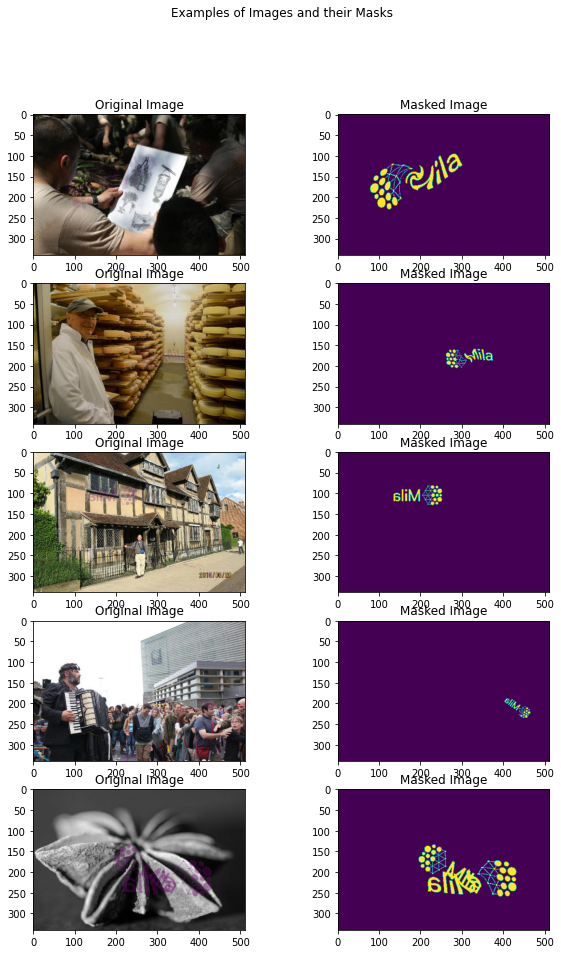

In [114]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = train_img_filenames[img_num]
  y_pathname = train_mask_filenames[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  filename = img_path + x_pathname
  plt.imshow(mpimg.imread(filename))
  plt.title("Original Image")
  
  example_labels = Image.open(mask_path + y_pathname)
  label_vals = np.unique(example_labels)
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

In [115]:
def datapoint_maker(x_pathname, y_pathname):
  
   images = Image.open(img_path + x_pathname) 
   masks = Image.open(mask_path + y_pathname)
   images = resize(asarray(images),(128,128))
   masks = resize(asarray(masks),(128,128))

   #check the number of channels because some of the images are RGBA or GRAY
   if len(images.shape) == 2:
          images = np.stack((images,)*3, axis=-1)

   else:
          images = images[:,:,0:3]

   if len(masks.shape) == 2:
          masks = np.stack((masks,)*1, axis=-1)

   else:
          masks = masks[:,:,0]  

   train_images = np.array(images)
   train_masks = np.array(masks)
   #print(images.shape)
   #print(masks.shape)
   return images, masks

In [116]:
def image_generator(train_img_filenames, batch_size = 2):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(range(len(train_img_filenames)), size = 2)     
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:
        #print(f)
        x_pathname = train_img_filenames[f]
        y_pathname = train_mask_filenames[f]
        images, masks = datapoint_maker(x_pathname, y_pathname)
    
        batch_y.append(masks)

        batch_x.append(images)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield batch_x, batch_y     
    

In [117]:
test_images = []
test_masks = []

print(len(test_img_filenames))
for f in range(len(test_img_filenames)):
  x_pathname = test_img_filenames[f]
  y_pathname = test_mask_filenames[f]
  
  images = Image.open(img_path + x_pathname) 
  masks = Image.open(mask_path + y_pathname)
  images = asarray(images)
  masks = asarray(masks)

  #check the number of channels because some of the images are RGBA or GRAY
  if len(images.shape) == 2:
          images = np.stack((images,)*3, axis=-1)

  else:
          images = images[:,:,0:3]

  if len(masks.shape) == 2:
          masks = np.stack((masks,)*1, axis=-1)

  else:
          masks = masks[:,:,0]
  
  test_images.append(images)
  test_masks.append(masks)

test_images = np.array(test_images)
test_masks = np.array(test_masks)
print(test_images.shape)
print(test_masks.shape)

1804
(1804, 340, 512, 3)
(1804, 340, 512, 1)


In [118]:
images, masks = datapoint_maker(train_img_filenames[3], train_mask_filenames[3])
images_test, masks_test = datapoint_maker(train_img_filenames[4], train_mask_filenames[4])
trainer = {'images':images, 'masks':masks}
tester = {'images':images_test, 'masks':masks_test}
print(type(trainer))

<class 'dict'>


The following code performs a simple normalization of image to [0,1]. Finally, as mentioned above the pixels in the segmentation mask are labeled either {0,1}. 

In [119]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  #input_mask -= 1#tf.cast(input_mask, tf.float32) / tf.math.reduce_max(input_mask)
  return input_image, input_mask

In [120]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['images'], (128, 128))
  input_mask = tf.image.resize(datapoint['masks'], (128, 128))
  '''
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
  '''
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['images'], (128, 128))
  input_mask = tf.image.resize(datapoint['masks'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [121]:
TRAIN_LENGTH = len(train_mask_filenames)  #info.splits['train'].num_examples
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = load_image_train(trainer)
test = load_image_test(tester)

print(train[0].shape)
print(train[1].shape)

(128, 128, 3)
(128, 128, 1)


In [122]:
train_dataset = image_generator(train_img_filenames, batch_size = 2)#train.batch(BATCH_SIZE)
test_dataset = image_generator(test_img_filenames, batch_size = 2)#test.batch(BATCH_SIZE)

Let's take a look at an image example and it's correponding mask from the dataset.

(128, 128, 1)


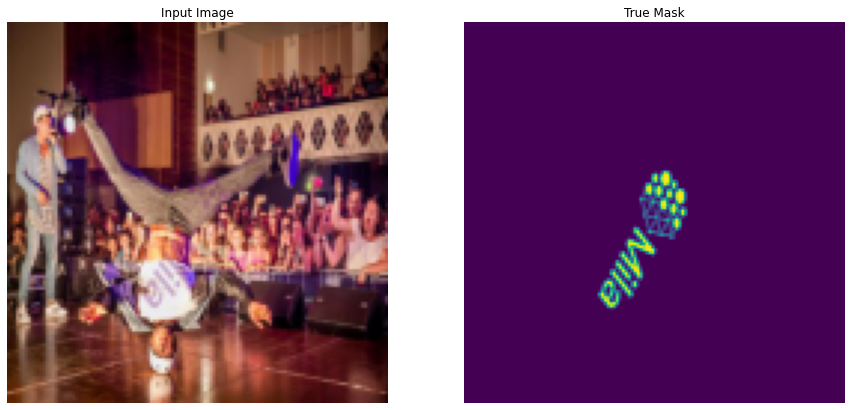

0.9978247


In [123]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

print(train[1].shape)
sample_image, sample_mask = train[0], train[1]
display([sample_image, sample_mask])

print(np.amax(sample_mask))

## Define the model
The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples.
The reason to output two channels is because there are two possible labels for each pixel. 

In [124]:
OUTPUT_CHANNELS = 2

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [125]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [126]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [127]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,           #2
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)
 

## Train the model
Now, all that is left to do is to compile and train the model. The loss being used here is `losses.BinaryCrossentropy(from_logits=True)`. The reason to use this loss function is because the network is trying to assign each pixel a label, just like binary-class prediction. In the true segmentation mask, each pixel has either a {0,1}. The network here is outputting two channels. Essentially, each channel is trying to learn to predict a class. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [128]:
def iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

def focal_loss_custom(alpha, gamma):
   def binary_focal_loss(y_true, y_pred):
      fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
      y_true_K = K.ones_like(y_true)
      focal_loss = fl(y_true, y_pred)
      return focal_loss
   return binary_focal_loss

In [129]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [130]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [137]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=focal_loss_custom(alpha=0.8, gamma=2.0),#tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[iou])

In [138]:
L = []
L.append(10000)

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 1
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
VALIDATION_STEPS = 1

for i in range(1000): 
  gc.collect()
  #x,y = train_dataset
  model_history = model.fit(train_dataset, epochs=1, steps_per_epoch=STEPS_PER_EPOCH,
                            validation_steps=VALIDATION_STEPS,
                            validation_data=test_dataset,callbacks=[DisplayCallback()]) 
  '''
  highest_loss = L[-1]
  L.append(model_history.history['loss'])
  #if model_history.history['loss'][0]<=highest_loss:
  model1.save('model1.h5')
  '''

Have a quick look at the resulting model architecture:

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [141]:
train[0].shape
out = model.predict(tf.reshape(train[0],(1,128,128,3)))
out1 = out[:,:,:,0]+out[:,:,:,1]
mask = np.reshape(out1,(128,128))


In [ ]:
plt.imshow(mask)
np.amax(mask)

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [150]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Script to benchmark a model on different test sets')
    parser.add_argument('--script_path', type=str, default='./infer.py',
                        help='path of the script to perform inference with the model')
    parser.add_argument('--testset_path', type=str, default='./test/',
                        help='path of the test sets')
    parser.add_argument('--prediction_path', type=str, default='./test/',
                        help='path of the directory where the predictions are saved')
    args = parser.parse_args()

    def call(interp_name, script_name, test_path, pred_path): 
      files = glob.glob (test_path +"/*.jpg")
      for myFile in files:
        # print(myFile)
        gc.collect()
        image = cv2.imread (myFile)
        image = resize(np.asarray(image),(128,128,3))
        X_data.append (image)
      X_data=np.asarray(X_data)
      print('Test X_data shape:', X_data.shape)

      model = keras.models.load_model(script_name)

      Y_pred = model.predict(X_data, batch_size = 4)
      t = 0
      for image in Y_pred:
        path = args.testset_path + path.split('/')[-1].split('.')[-2] + '.bmp'
        skimage.io.imsave(path, image)







    test_dirs = os.listdir(args.testset_path)
    if not test_dirs:
        test_dirs.append('.')

    score_dict = {}

    script_dir = os.path.dirname(args.script_path)
    script_name = os.path.basename(args.script_path)
    interp_name = './'
    if os.path.splitext(script_name)[1] == '.py':
        interp_name = 'python'
    elif os.path.splitext(script_name)[1] == '.sh':
        interp_name = 'sh'

    for test_name in test_dirs:
        pred_path = os.path.join(args.prediction_path, test_name)
        if not os.path.isdir(pred_path):
            current_wd = os.getcwd()
            os.chdir(script_dir)
            print('Generating the predictions for {} set'.format(test_name))
            call([interp_name, script_name, os.path.join(args.testset_path, test_name, 'img'), pred_path])
            print('Generation done.')
            os.chdir(current_wd)

        test_mask_path = os.path.join(args.testset_path, test_name, 'mask')
        score = compute_metrics(iou, pred_path=pred_path, mask_path=test_mask_path)
        score_dict[test_name] = score

    if len(test_dirs) == 1:
        print('mean IOU on {}: {:.4f}'.format(test_name, score_dict[test_name]))
    else:
        for test_name in test_dirs:
            print('mean IOU on {}: {:.4f}'.format(test_name, score_dict[test_name]))


usage: ipykernel_launcher.py [-h] [--script_path SCRIPT_PATH]
                             [--testset_path TESTSET_PATH]
                             [--prediction_path PREDICTION_PATH]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-e6c336cb-e58a-4704-a6df-9c03caf2fd16.json


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
def call():

So to make sample weights for this tutorial you need a function that takes a `(data, label)` pair and returns a `(data, label, sample_weight)` triple. Where the `sample_weight` is a 1-channel image containing the class weight for each pixel. 

The simplest possible implementation is to use the label as an index into a `class_weight` list:

In [ ]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([1.0, 10.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [ ]:
add_sample_weights(train_dataset,1)

In [ ]:
weighted_model = model
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[iou])

In [ ]:
weighted_model.fit(
    add_sample_weights([train_dataset],1),
    epochs=1,
    steps_per_epoch=10)